# Hab Dishab Dopamine Analysis

DA data

In [39]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment
from hd_extension import *

In [40]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all/nac"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all_csvs/nac_csvs"
brain_region = '#FFAF00'

# NAc: #15616F
# mPFC: #FFAF00

# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\mpfc"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All_csvs\mpfc_csvs"
# brain_region = '#FFAF00'

In [41]:
bout_definitions = [
    {'prefix': 's1', 'introduced': 's1_Introduced', 'removed': 's1_Removed'},
    {'prefix': 's2', 'introduced': 's2_Introduced', 'removed': 's2_Removed'}
]

In [42]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all/nac/n7-240821-114717/Notes.txt
read from t=0s to t=1309.86s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all/nac/nn7-250114-100133/Notes.txt
read from t=0s to t=1376.66s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all/nac/nn3-250115-064154/Notes.txt
read from t=0s to t=1377.67s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all/nac/n6-240821-100116/Notes.txt
read from t=0s to t=1335.06s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all/nac/nn1-250115-052028/Notes.txt
read from t=0s to t=1351.05s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all/nac/nn4

### Peak standard z-score

In [ ]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, #otal_avg_bout_duration
                                  use_adaptive=False, 
                                  allow_bout_extension=False,
                                  mode='standard')

In [ ]:
exp_da_dict = get_trial_dataframes(experiment)

In [ ]:
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']
da_metadata_df = create_da_metrics_dataframe(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

In [ ]:
da_metadata_df.head(6)

In [ ]:
def plot_behavior_times_across_bouts_gray(metadata_df,
                                          y_col="Total Investigation Time",
                                          behavior=None,
                                          title='Mean Across Bouts',
                                          ylabel=None,
                                          custom_xtick_labels=None,
                                          custom_xtick_colors=None,
                                          ylim=None,
                                          bar_color='#00B7D7',
                                          yticks_increment=None,
                                          xlabel='Agent',
                                          figsize=(12, 7),
                                          pad_inches=0.1,
                                          save=False,
                                          save_name=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import ttest_rel

    # 1) Optionally filter by behavior
    if behavior is not None:
        metadata_df = metadata_df[metadata_df["Behavior"] == behavior].copy()
        if metadata_df.empty:
            raise ValueError(f"No data found for behavior='{behavior}'.")

    # 2) Check if the desired y_col exists
    if y_col not in metadata_df.columns:
        raise ValueError(f"'{y_col}' not found in metadata_df columns.")

    # 3) Pivot the DataFrame: rows -> Subjects, columns -> Bout, values -> y_col
    pivot_df = metadata_df.pivot(index="Subject", columns="Bout", values=y_col)

    # 4) Calculate mean and SEM across subjects for each bout
    mean_values = pivot_df.mean()
    sem_values = pivot_df.sem()

    # 5) Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # 6) Bar plot with error bars (SEM)
    bars = ax.bar(
        pivot_df.columns,
        mean_values,
        yerr=sem_values,
        capsize=6,
        color=bar_color,
        edgecolor='black',
        linewidth=5,
        width=0.6,
        error_kw=dict(elinewidth=3, capthick=3, zorder=5)
    )

    # 7) Plot individual subject data in gray
    for subject in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[subject],
                linestyle='-', color='gray', alpha=0.5,
                linewidth=2.5, zorder=1)
        ax.scatter(pivot_df.columns, pivot_df.loc[subject],
                   facecolors='none', edgecolors='gray',
                   s=120, alpha=0.6, linewidth=4, zorder=2)

    # 8) Labels
    if ylabel is None:
        ylabel = y_col
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # 9) X-ticks
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # 10) Y-limits
    if ylim is None:
        all_vals = np.concatenate([pivot_df.values.flatten(), mean_values.values.flatten()])
        min_val = np.nanmin(all_vals)
        max_val = np.nanmax(all_vals)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # 11) Custom Y-ticks
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # 12) Spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    plt.tight_layout()
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)

    plt.show()

    # 13) Paired t-tests
    comparisons = [("s1-1", "s1-2"), ("s1-5", "s2-1")]
    print("\nPaired t-test results:")
    for a, b in comparisons:
        if a in pivot_df.columns and b in pivot_df.columns:
            paired = pivot_df[[a, b]].dropna()
            if len(paired) > 1:
                t_stat, p_val = ttest_rel(paired[a], paired[b])
                stars = "ns"
                if p_val < 0.001:
                    stars = "***"
                elif p_val < 0.01:
                    stars = "**"
                elif p_val < 0.05:
                    stars = "*"
                print(f"{a} vs {b}: p = {p_val:.4f} ({stars})")
            else:
                print(f"{a} vs {b}: Not enough data.")
        else:
            print(f"{a} vs {b}: Bout not found in data.")


In [ ]:
# Average Bout Duration Across Bouts
plot_behavior_times_across_bouts_gray(
    metadata_df=da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title=None,
    xlabel="Intruder",
    ylabel="Peak Z-scored ΔF/F",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(-2, 10),
    bar_color=brain_region,
    yticks_increment=4,
    figsize=(12,7),
    pad_inches=0.1,
    save=True,
    save_name=r"mPFC_C1_3_Peak"
)

In [ ]:
# Average Bout Duration Across Bouts
plot_behavior_times_across_bouts_colored(
    metadata_df=da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title="1st Investiagtion Peak standard z-score DA Across Bouts",
    xlabel="Intruder",
    ylabel="Peak standard z-score DA",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(-2, 15),
    bar_color=brain_region,
    yticks_increment=2,
    figsize=(12,7),
    pad_inches=0.1,
    save=False,
    save_name=r"Hab_Dishab_Plots\mPFC_DA\mPFC_C1-3_Peak_Across_Bouts_WIDENTITIES.png"
)

In [43]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, #otal_avg_bout_duration
                                  
                                  
                                  mode='standard')

Processing behaviors for n7-240821-114717...
Processing behaviors for nn7-250114-100133...
Processing behaviors for nn3-250115-064154...
Processing behaviors for n6-240821-100116...
Processing behaviors for nn1-250115-052028...
Processing behaviors for nn4-250115-072812...
Processing behaviors for nn2-250115-054951...
Processing behaviors for nn5-250114-083827...
Processing behaviors for nn6-250114-093117...
Processing behaviors for nn8-250114-103839...
Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for nn7-250114-100133 ...
Computing DA metrics for nn3-250115-064154 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for nn1-250115-052028 ...
Computing DA metrics for nn4-250115-072812 ...
Computing DA metrics for nn2-250115-054951 ...
Computing DA metrics for nn5-250114-083827 ...
Computing DA metrics for nn6-250114-093117 ...
Computing DA metrics for nn8-250114-103839 ...


In [44]:
exp_da_dict = get_trial_dataframes(experiment)
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']


In [45]:
def plot_peak_for_subsequent_investigations_custom(
    exp_da_dict,
    selected_bouts=None,
    n_subsequent_investigations=3,
    peak_col="Max Peak",
    metric_type='slope',
    figsize=(14, 8),
    line_order=None,
    custom_colors=None,
    custom_legend_labels=None,
    custom_xtick_labels=None,
    ylim=None,
    ytick_increment=None,
    xlabel="Investigation Index",
    ylabel="Avg " + "Max Peak",
    plot_title="Average Peak per Investigation"
):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import linregress
    from scipy.optimize import curve_fit

    def exponential_decay(x, A, B, tau):
        return A + B * np.exp(-x / tau)

    def create_big_df_from_exp_da_dict(exp_da_dict):
        import pandas as pd
        return pd.concat([df.assign(Subject=subj) for subj, df in exp_da_dict.items() if not df.empty], ignore_index=True)

    big_df = create_big_df_from_exp_da_dict(exp_da_dict)

    if selected_bouts is not None:
        big_df = big_df[big_df["Bout"].isin(selected_bouts)].copy()

    if big_df.empty:
        print("No data left after filtering for bouts. Nothing to plot.")
        return pd.DataFrame()

    big_df.sort_values(["Subject", "Bout", "Event_Start"], inplace=True)
    big_df["InvestigationIndex"] = big_df.groupby(["Subject", "Bout"]).cumcount() + 1
    big_df = big_df[big_df["InvestigationIndex"] <= n_subsequent_investigations]

    agg_df = (
        big_df.groupby(["Bout", "InvestigationIndex"], as_index=False)
        .agg(
            SubjectCount=("Subject", "nunique"),
            AvgPeak=(peak_col, "mean")
        )
    )

    if custom_colors is None:
        custom_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.tick_params(axis="both", which="major", labelsize=48)

    metrics_dict = {}

    if line_order is None:
        unique_bouts = sorted(agg_df["Bout"].unique())
    else:
        unique_bouts = line_order

    for i, bout in enumerate(unique_bouts):
        df_line = agg_df[agg_df["Bout"] == bout].copy()
        df_line.sort_values("InvestigationIndex", inplace=True)

        x_vals = df_line["InvestigationIndex"].values
        y_vals = df_line["AvgPeak"].values

        if len(x_vals) == 0 or len(y_vals) == 0:
            print(f"Skipping bout '{bout}' due to no data.")
            continue

        # Compute slope or decay
        if metric_type.lower() == 'slope':
            slope, intercept, r_val, p_val, std_err = linregress(x_vals, y_vals)
            metrics_dict[bout] = slope
            metric_label = f"slope: {slope:.3f}"
        elif metric_type.lower() == 'decay':
            p0 = (np.min(y_vals), np.max(y_vals) - np.min(y_vals), 1.0)
            try:
                popt, _ = curve_fit(exponential_decay, x_vals, y_vals, p0=p0)
                tau = popt[2]
                metrics_dict[bout] = tau
                metric_label = f"decay: {tau:.3f}"
            except RuntimeError:
                metrics_dict[bout] = np.nan
                metric_label = "decay: N/A"
                print(f"Warning: exponential fit failed for bout '{bout}'.")
        else:
            raise ValueError("metric_type must be 'slope' or 'decay'.")

        subject_n = df_line["SubjectCount"].max()
        legend_text = f"i{i+1} ({metric_label}, n={subject_n})"

        color = custom_colors[i % len(custom_colors)]
        ax.plot(
            x_vals, y_vals,
            marker='o', linestyle='-',
            color=color,
            linewidth=5, markersize=30,
            label=legend_text
        )

    ax.set_xlabel(xlabel, fontsize=35, labelpad=12)
    ax.set_ylabel(ylabel, fontsize=35, labelpad=12)

    if ylim is not None:
        ax.set_ylim(ylim)
        if ytick_increment is not None:
            y_ticks = np.arange(ylim[0], ylim[1] + ytick_increment, ytick_increment)
            ax.set_yticks(y_ticks)
            y_tick_labels = [f"{int(yt)}" if float(yt).is_integer() else f"{yt:.1f}" for yt in y_ticks]
            ax.set_yticklabels(y_tick_labels, fontsize=35)
        else:
            ax.tick_params(axis='y', labelsize=35)


    if custom_xtick_labels:
        ax.set_xticks(np.arange(1, len(custom_xtick_labels) + 1))
        ax.set_xticklabels(custom_xtick_labels, fontsize=35)
    else:
        unique_x = sorted(agg_df["InvestigationIndex"].unique())
        ax.set_xticks(unique_x)
        ax.set_xticklabels([str(x) for x in unique_x], fontsize=35)

    if plot_title:
        ax.set_title(plot_title, fontsize=1)

    ax.legend(fontsize=26)
    plt.tight_layout()
    plt.savefig("my_plot.png", transparent=True, dpi=300)
    plt.show()

    print(f"\n=== Computed Metric ({metric_type.upper()}): ===")
    for bout, val in metrics_dict.items():
        print(f"Bout: {bout}, {metric_type} = {val:.3f}")

    return agg_df

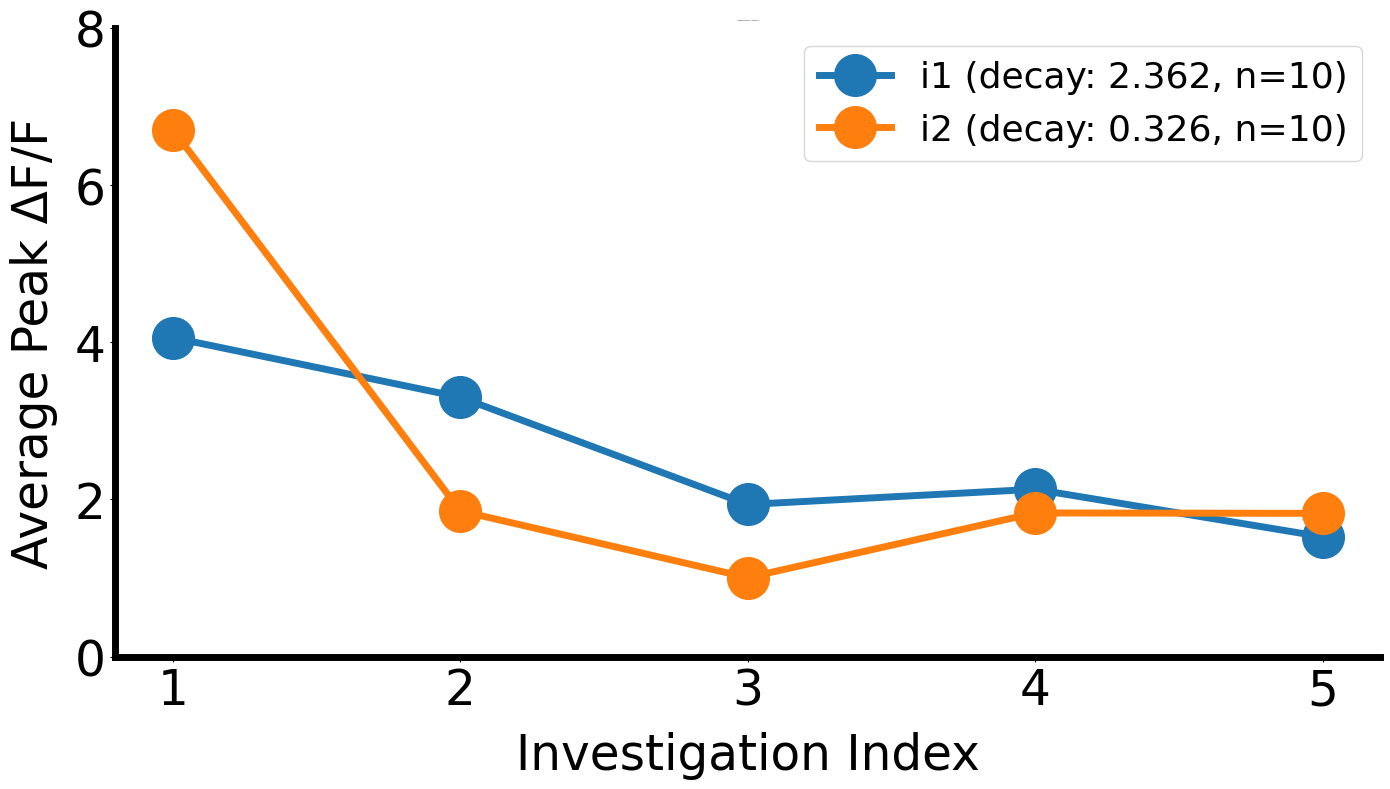


=== Computed Metric (DECAY): ===
Bout: s1-1, decay = 2.362
Bout: s2-1, decay = 0.326


In [46]:
# Suppose exp_da_dict = {"nn8": df_nn8, "nn3": df_nn3, ...}

# Plot the first 3 investigations for bouts s1-1 and s1-2:
df_final = plot_peak_for_subsequent_investigations_custom(
    exp_da_dict,
    selected_bouts=["s1-1", "s2-1"],
    n_subsequent_investigations=5,
    peak_col="Max Peak",
    metric_type='decay', 
    ylabel="Average Peak ΔF/F",
    ylim=(0, 8),
    ytick_increment=2
)


In [ ]:
df_final